In [1]:
from sklearn import datasets         
import numpy as np                         
import pandas as pd
import matplotlib.pyplot as plt

# Iris Data

In [2]:
iris = datasets.load_iris()
iris_np = np.concatenate((iris.data, np.expand_dims(iris.target, axis=1)), axis=1)
iris_df = pd.DataFrame(iris_np, columns=['SL','SW','PL','PW', 'Class'] )
outlier_df = pd.DataFrame([[3,5,6,3, 1]], columns=['SL','SW','PL','PW', 'Class'], index=[150] )
iris_df = iris_df.append(outlier_df, ignore_index=False)
iris.data = iris_df[['SL','SW','PL','PW']].to_numpy()
N = iris_df.shape[0]

C:\Users\devil\AppData\Local\Temp\ipykernel_40148\3051050915.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iris_df = iris_df.append(outlier_df, ignore_index=False)


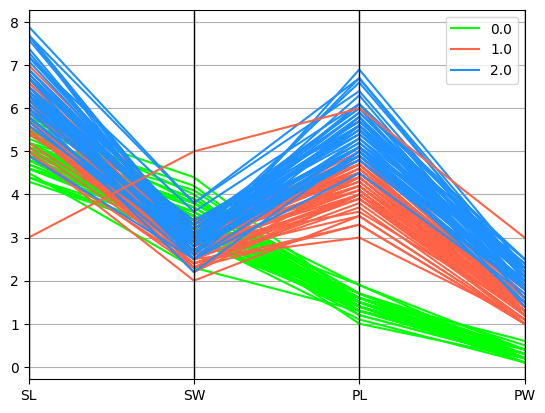

In [3]:
pd.plotting.parallel_coordinates(frame=iris_df, 
                                 class_column="Class", 
                                 color=["lime", "tomato","dodgerblue"],
                                 use_columns=['SL','SW','PL','PW']
                                 );

# Univariate 

## Z scores

In [4]:
iris_mean = np.mean(iris.data, axis=0)
iris_std = np.std(iris.data, axis=0)
iris_z = (iris.data - iris_mean)/iris_std
iris_z_df = pd.DataFrame(iris_z, columns=['SL_z','SW_z','PL_z','PW_z'])

iris_plus_df =  pd.concat([iris_df, iris_z_df], axis=1)

### Boxplot

<AxesSubplot: >

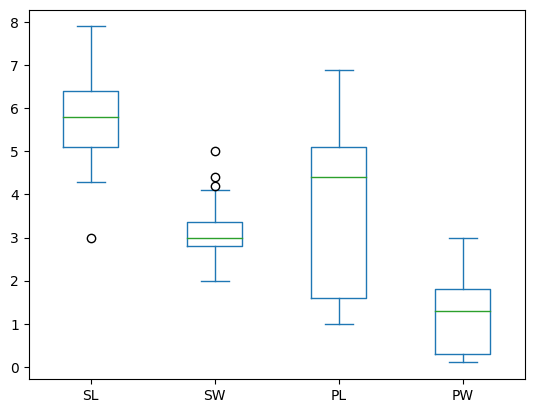

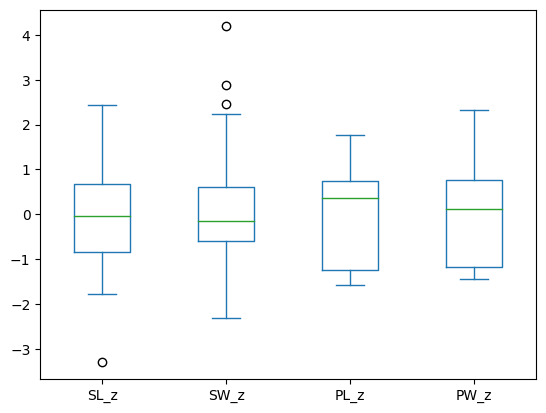

In [5]:
iris_df[['SL','SW','PL','PW']].plot(kind='box')
iris_z_df.plot(kind='box')

### Parallel Coordinates

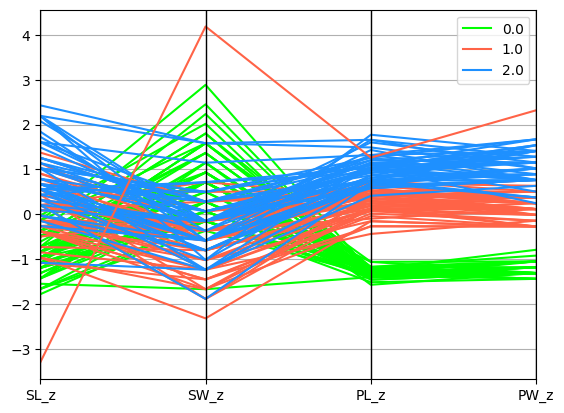

In [6]:
pd.plotting.parallel_coordinates(
    frame=iris_plus_df[['SL_z','SW_z','PL_z','PW_z', 'Class']], 
    class_column="Class", 
    color=["lime", "tomato","dodgerblue"]
    );

## t Scores

In [7]:
from scipy.stats import t
alpha = 0.95
t_val = t.ppf(1 - alpha / (2 * N), N - 2)
grubs_threshold = ((N-1)/np.sqrt(N)) * (np.sqrt(t_val**2 / ((N-2 + t_val**2))))
grubs_threshold

2.702788543647612

## Grubs Test

In [8]:
iris_plus_df['SL_grub'] = iris_plus_df['SL_z'].abs() >= grubs_threshold
iris_plus_df['SW_grub'] = iris_plus_df['SW_z'].abs() >= grubs_threshold
iris_plus_df['PL_grub'] = iris_plus_df['PL_z'].abs() >= grubs_threshold
iris_plus_df['PW_grub'] = iris_plus_df['PW_z'].abs() >= grubs_threshold

### Visualize Outliers

<Figure size 1000x300 with 0 Axes>

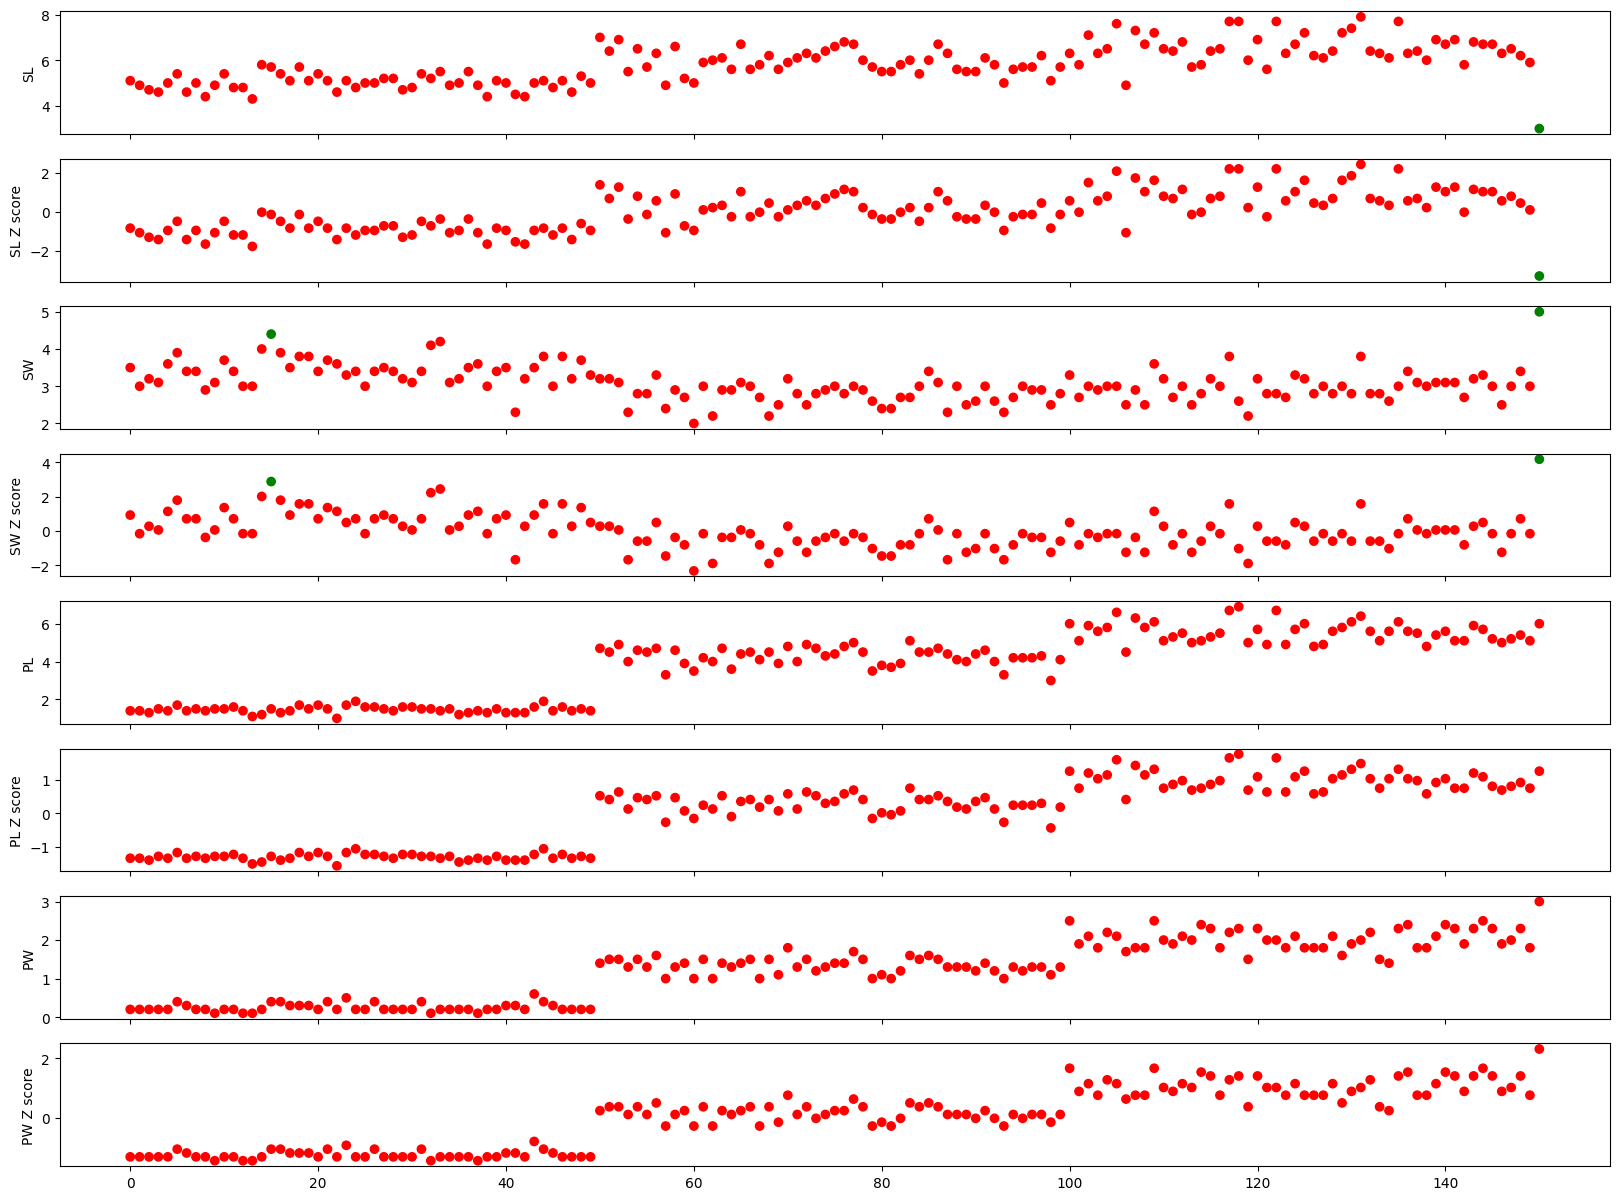

In [9]:
plt.figure(figsize=(10, 3))
fig, ax = plt.subplots(8, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(20)
colors = {True:'green', False:'red'}
ax[0].scatter(x=range(N), y=iris_plus_df.SL, c=iris_plus_df.SL_grub.map(colors))
ax[0].set_ylabel('SL')
ax[1].scatter(x=range(N), y=iris_plus_df.SL_z, c=iris_plus_df.SL_grub.map(colors))
ax[1].set_ylabel('SL Z score')
ax[2].scatter(x=range(N), y=iris_plus_df.SW, c=iris_plus_df.SW_grub.map(colors))
ax[2].set_ylabel('SW')
ax[3].scatter(x=range(N), y=iris_plus_df.SW_z, c=iris_plus_df.SW_grub.map(colors))
ax[3].set_ylabel('SW Z score')
ax[4].scatter(x=range(N), y=iris_plus_df.PL, c=iris_plus_df.PL_grub.map(colors))
ax[4].set_ylabel('PL')
ax[5].scatter(x=range(N), y=iris_plus_df.PL_z, c=iris_plus_df.PL_grub.map(colors))
ax[5].set_ylabel('PL Z score')
ax[6].scatter(x=range(N), y=iris_plus_df.PW, c=iris_plus_df.PW_grub.map(colors))
ax[6].set_ylabel('PW')
ax[7].scatter(x=range(N), y=iris_plus_df.PW_z, c=iris_plus_df.PW_grub.map(colors))
ax[7].set_ylabel('PW Z score')

plt.show()

# Multivariate

## Aggregated Z Scores

In [10]:
iris_plus_df['Z_agg'] = (iris_plus_df[['SL_z','SW_z','PL_z','PW_z']]**2).sum(axis=1)

## Chi-Square Testing

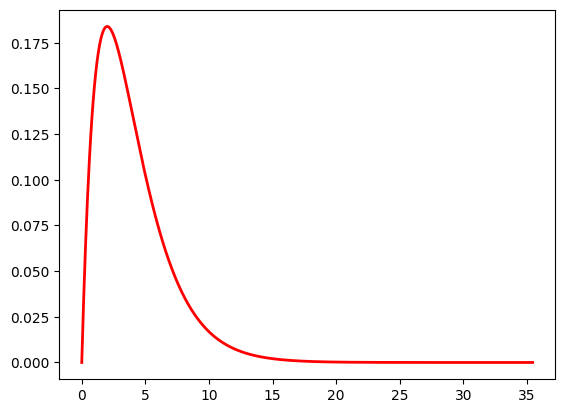

In [11]:
from scipy.stats import chi2
x = np.arange(0, iris_plus_df.Z_agg.max(), .05)
plt.plot(x, chi2.pdf(x, df=4), color='r', lw=2)
plt.show()

In [12]:
# threshold from Chi-Sqaure Distribution for detecting outliers 
threshold = chi2.ppf(q= 0.95,  # lower tail probability
                     df=4)
threshold

9.487729036781154

In [13]:
# outliers
iris_plus_df[iris_plus_df.Z_agg > threshold][['SL','SW','PL','PW', 'Z_agg','Class']]
iris_plus_df['Z_agg_Outlier'] = iris_plus_df.Z_agg > threshold

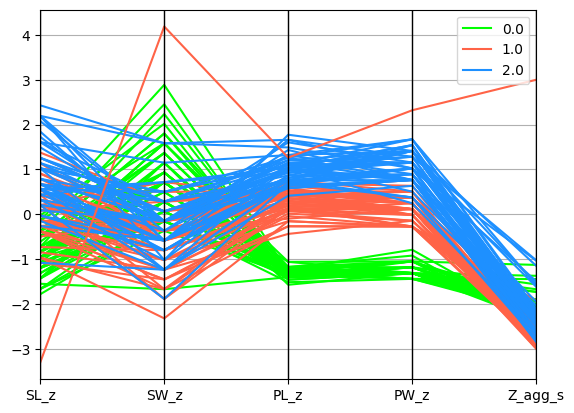

In [14]:
iris_plus_df['Chi2_pdf'] = chi2.pdf(iris_plus_df['Z_agg'], df=4)
iris_plus_df['Chi2_pdf'] = 1 - chi2.cdf(iris_plus_df['Z_agg'], df=4)
iris_plus_df['Chi2_sf'] = chi2.sf(iris_plus_df['Z_agg'], df=4) # survival function (1 - cdf) or p-value
iris_plus_df['Chi2_logsf'] = chi2.logsf(iris_plus_df['Z_agg'], df=4)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-3,3))
iris_plus_df['Z_agg_s'] = scaler.fit_transform(iris_plus_df[['Z_agg']])
pd.plotting.parallel_coordinates(iris_plus_df[['SL_z','SW_z','PL_z','PW_z', 'Z_agg_s', 'Class']], "Class", color=["lime", "tomato","dodgerblue"]);

<Figure size 1000x300 with 0 Axes>

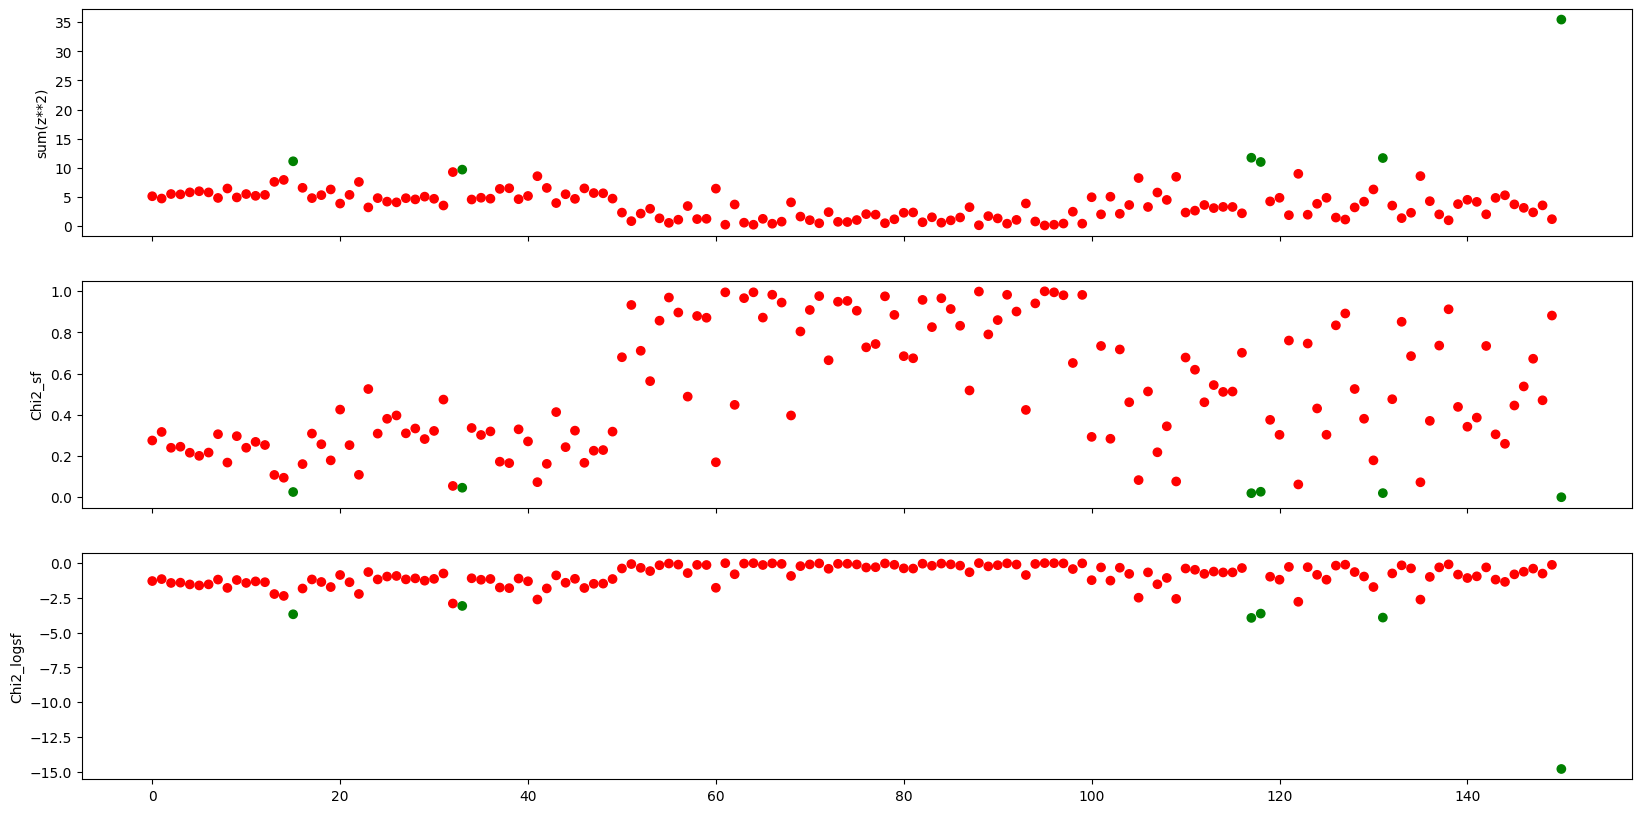

In [15]:
iris_std = np.std(iris.data, axis=0)
iris_z_agg = (iris_z**2).sum(axis=1)
plt.figure(figsize=(10, 3))
fig, ax = plt.subplots(3, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(20)
colors = {True:'green', False:'red'}
ax[0].scatter(x=range(N), y=iris_plus_df['Z_agg'], c=iris_plus_df.Z_agg_Outlier.map(colors))
ax[0].set_ylabel('sum(z**2)')
ax[1].scatter(x=range(N), y=iris_plus_df['Chi2_sf'], c=iris_plus_df.Z_agg_Outlier.map(colors))
ax[1].set_ylabel('Chi2_sf')
ax[2].scatter(x=range(N), y=iris_plus_df['Chi2_logsf'], c=iris_plus_df.Z_agg_Outlier.map(colors))
ax[2].set_ylabel('Chi2_logsf')
plt.show()

## Mahalanobis Distance

In [16]:
# Covariance matrix
cov  = np.cov(iris.data , rowvar=False)
# Covariance matrix power of -1
invcov = np.linalg.matrix_power(cov, -1)
# mean vector
iris_mean = np.mean(iris.data , axis=0).T

In [17]:
mahal_dist = []
df = iris_df[['SL', 'SW','PL','PW']]
for i, iris_row in df.iterrows():
      d = (iris_row.to_numpy()-iris_mean).T.dot(invcov).dot(iris_row-iris_mean)
      mahal_dist.append(d)
iris_plus_df['mahal_dist'] = mahal_dist

### Mahalanobix Outliers

In [18]:
# outliers
iris_plus_df[iris_plus_df.mahal_dist > threshold][['SL','SW','PL','PW', 'Z_agg','Class']]
iris_plus_df['mahal_Outlier'] = iris_plus_df.mahal_dist > threshold

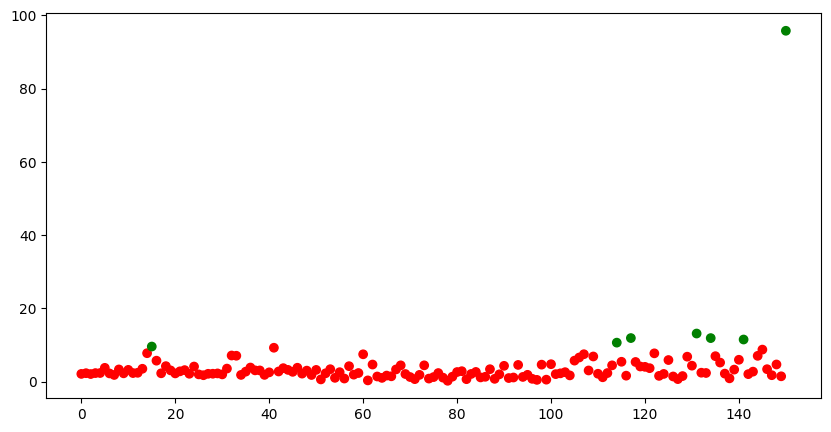

In [19]:
fig, ax = plt.subplots(1, sharex=True)
fig.set_figheight(5)
fig.set_figwidth(10)
colors = {True:'green', False:'red'}
ax.scatter(x=range(N), y=iris_plus_df['mahal_dist'], c=iris_plus_df.mahal_Outlier.map(colors))
plt.show()

# [Local Outlier Factor](https://dl.acm.org/doi/10.1145/335191.335388)
- assign to each object a degree (local outlier factor) of being an outlier.
- It is local --> depends on how isolated the object is with respect to the surrounding neighborhood. 
  - for each point: distances from other points
    - K nearest points
    - farthest-NN 
    - local reachability density = (# of NNs) / (farthest NN distance) --> (lrd_point)
    - for each NN:     
      - local reachability density (ldf_nebor)
      - sum(lrd_nebor / lrd_point) / (# of NNs)

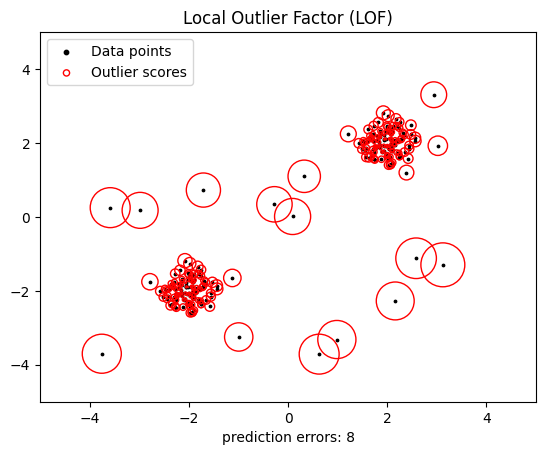

In [20]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()